# Basic Predictive Model for McKenzie River @ Vida

### Import relevant packages

In [110]:
import ssl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from datetime import datetime, timedelta
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
ssl._create_default_https_context = ssl._create_unverified_context

#### Fetch SWE Data

Pull out data from a sensor in the Mckenzie drainage containing:
* Snow Water Equivalent : Metric for the amount of precip stored in snow
* Temperature data including daily high low and average

In [3]:
# Fetch SWE data for Mckenzie basin. Atuomatically retrieves all data up to present.
url ='https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/619:OR:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value'
swe_df = pd.read_csv(url, comment='#')

# Filter out first 2900 results (yields same start date as water data to follow)
swe_df = swe_df.iloc[2900:]
swe_df = swe_df.reset_index()

# Updates 1 day ahead of water data, strip most recent result
swe_df.drop(swe_df.tail(1).index,inplace=True)

#### Fetch Water Level Data

In [194]:
# Get todays date and format it
today = datetime.today()  - timedelta(days=1)
today = today.strftime("%Y-%m-%d")
print(today)

2021-04-24


In [5]:
# Based on today's date, fetch all relevant water data
water_url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=14162500&referred_module=sw&period=&begin_date=1988-10-12&end_date=' + today
water_df = pd.read_csv(water_url, sep='\t', comment='#')
water_df = water_df.drop(0).reset_index()
water_df = water_df.drop(columns=['index', 'agency_cd', 'site_no', '172063_00060_00003_cd'])
print(water_df)

         datetime 172063_00060_00003
0      1988-10-12               2230
1      1988-10-13               2240
2      1988-10-14               2000
3      1988-10-15               1770
4      1988-10-16               1770
...           ...                ...
11878  2021-04-20               2960
11879  2021-04-21               2930
11880  2021-04-22               2920
11881  2021-04-23               2900
11882  2021-04-24               2900

[11883 rows x 2 columns]


#### Extract data into dataframes

In [91]:
water = water_df
swe = swe_df

#### Check that data & dates align

In [92]:
water

,datetime,172063_00060_00003
0,1988-10-12,2230
1,1988-10-13,2240
2,1988-10-14,2000
3,1988-10-15,1770
4,1988-10-16,1770
...,...,...
11878,2021-04-20,2960
11879,2021-04-21,2930
11880,2021-04-22,2920
11881,2021-04-23,2900


In [93]:
swe

,index,Date,Snow Water Equivalent (in) Start of Day Values,Precipitation Accumulation (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),date,level
0,2900,1988-10-12,0.0,0.0,32.0,32.0,32.0,0.0,1988-10-12,2230
1,2901,1988-10-13,0.0,0.0,32.0,32.0,32.0,0.2,1988-10-13,2240
2,2902,1988-10-14,0.0,0.2,NaN,NaN,NaN,0.0,1988-10-14,2000
3,2903,1988-10-15,0.0,0.2,32.0,32.0,32.0,0.0,1988-10-15,1770
4,2904,1988-10-16,0.0,0.2,32.0,32.0,32.0,0.0,1988-10-16,1770
...,...,...,...,...,...,...,...,...,...,...
11878,14778,2021-04-20,34.3,70.7,52.0,36.0,43.0,0.0,2021-04-20,2960
11879,14779,2021-04-21,33.2,70.7,58.0,29.0,44.0,0.0,2021-04-21,2930
11880,14780,2021-04-22,32.4,70.7,54.0,27.0,40.0,NaN,2021-04-22,2920
11881,14781,2021-04-23,31.7,70.6,56.0,22.0,40.0,0.1,2021-04-23,2900


In [94]:
# Assert that shape is the same
assert (water.shape[0] == swe.shape[0])
# Assert that date is consistent for an arbitrary row
assert(swe.loc[1000]['Date'] == water.loc[1000]['datetime'])

#### Condense all data into a single dataframe

In [95]:
# Clone SWE into df
df = swe

In [96]:
# copy relevant columns from water into df
df['date'] = water['datetime']
df['level'] = water['172063_00060_00003']

In [97]:
# Drop irrelevant columns
df = df.drop(columns=['index', 'Date', 'date', 'Precipitation Accumulation (in) Start of Day Values'])

In [98]:
# OPTIONAL: Grab most recent 50 days for prediction testing
df_pred_test = df[-50:]
df = df[:-50]

In [99]:
# Print the new dataframe
df

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),level
0,0.0,32.0,32.0,32.0,0.0,2230
1,0.0,32.0,32.0,32.0,0.2,2240
2,0.0,NaN,NaN,NaN,0.0,2000
3,0.0,32.0,32.0,32.0,0.0,1770
4,0.0,32.0,32.0,32.0,0.0,1770
...,...,...,...,...,...,...
11828,37.9,51.0,22.0,34.0,0.0,4080
11829,37.8,52.0,23.0,35.0,0.0,3980
11830,37.9,57.0,18.0,34.0,0.0,3910
11831,37.8,54.0,20.0,40.0,0.0,3790


In [101]:
# Create a new column containing the level from the previous day
rows = df.shape[0]
columns = df.shape[1]
row = 1
for row_idx in range(1, rows):
    df.at[row_idx, 'level day before'] = df.loc[row_idx-1]['level']

In [102]:
# Count NaN values
df.isna().sum()

Snow Water Equivalent (in) Start of Day Values      1
Air Temperature Maximum (degF)                    141
Air Temperature Minimum (degF)                    154
Air Temperature Average (degF)                    158
Precipitation Increment (in)                        1
level                                               0
level day before                                    1
dtype: int64

In [104]:
# Drop them and recount
df=df.dropna()
df.isna().sum()

Snow Water Equivalent (in) Start of Day Values    0
Air Temperature Maximum (degF)                    0
Air Temperature Minimum (degF)                    0
Air Temperature Average (degF)                    0
Precipitation Increment (in)                      0
level                                             0
level day before                                  0
dtype: int64

In [105]:
# Display the new dataframe
df

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),level,level day before
1,0.0,32.0,32.0,32.0,0.2,2240,2230
3,0.0,32.0,32.0,32.0,0.0,1770,2000
4,0.0,32.0,32.0,32.0,0.0,1770,1770
5,0.0,32.0,32.0,32.0,0.0,1760,1770
6,0.0,32.0,32.0,32.0,0.0,1760,1760
...,...,...,...,...,...,...,...
11828,37.9,51.0,22.0,34.0,0.0,4080,4140
11829,37.8,52.0,23.0,35.0,0.0,3980,4080
11830,37.9,57.0,18.0,34.0,0.0,3910,3980
11831,37.8,54.0,20.0,40.0,0.0,3790,3910


In [106]:
# Swap the final two columns so that current level is rightmost
columns_titles = ['Snow Water Equivalent (in) Start of Day Values',
       'Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)',
       'Air Temperature Average (degF)', 'Precipitation Increment (in)', 'level day before',
       'level']
df=df.reindex(columns=columns_titles)
df

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),level day before,level
1,0.0,32.0,32.0,32.0,0.2,2230,2240
3,0.0,32.0,32.0,32.0,0.0,2000,1770
4,0.0,32.0,32.0,32.0,0.0,1770,1770
5,0.0,32.0,32.0,32.0,0.0,1770,1760
6,0.0,32.0,32.0,32.0,0.0,1760,1760
...,...,...,...,...,...,...,...
11828,37.9,51.0,22.0,34.0,0.0,4140,4080
11829,37.8,52.0,23.0,35.0,0.0,4080,3980
11830,37.9,57.0,18.0,34.0,0.0,3980,3910
11831,37.8,54.0,20.0,40.0,0.0,3910,3790


In [129]:
#OPTIONAL DROP - may yield higher accuracy if both are included
df = df.drop(columns=['Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)'])

In [130]:
# Separate train/test data
X, y = df.iloc[:,:-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [132]:
# build a pipeline, model TBD
pipe = make_pipeline(StandardScaler(),
                     Ridge(alpha=1))

In [133]:
# train pipeline 
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1))])

In [134]:
# predict test set
y_pred = pipe.predict(X_test)
# display accuracy
print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))

Test Accuracy: 0.914


In [135]:
# Fix silly nparray/dtype format
y_test = y_test.tolist()
y_test = [int(i) for i in y_test]
y_pred = y_pred.tolist()
y_pred = [int(i) for i in y_pred]
y_pred = np.array(y_pred)
y_test = np.array(y_test)

Text(0.5, 1.0, 'True vs Predicted')

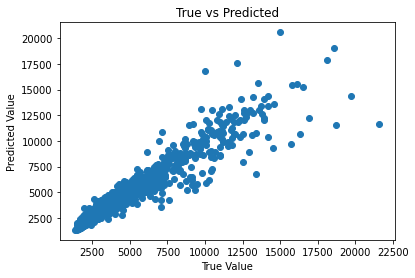

In [138]:
# make a scatter plot of 'true' vs 'predicted'
x = y_test
y = y_pred
#m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
#plt.plot(x, m*x + b, color='red')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("True vs Predicted")

In [139]:
X_test

array([[0.0, 43.0, 0.7, '2110'],
       [0.0, 60.0, 0.1, '2640'],
       [0.0, 43.0, 0.0, '2930'],
       ...,
       [0.0, 49.0, 0.0, '2880'],
       [0.0, 72.0, 0.0, '2480'],
       [52.2, 32.0, 0.4, '5430']], dtype=object)

In [140]:
df.columns

Index(['Snow Water Equivalent (in) Start of Day Values',
       'Air Temperature Average (degF)', 'Precipitation Increment (in)',
       'level day before', 'level'],
      dtype='object')

In [164]:
def predict_level(swe=[], days=1, temps=[], precips=[], cur_level=[]):
    assert len(swe) == len(temps) == len(precips) == days
    df = pd.DataFrame(list(zip(swe,temps,precips,cur_level)),
        columns = ['Snow Water Equivalent (in) Start of Day Values',
       'Air Temperature Average (degF)', 'Precipitation Increment (in)', 'level day before'])
    return df

In [168]:
df_example_pred = predict_level(swe=[8, 9], days=2, temps=[30,20], precips=[20,22], cur_level=[2000,2000])

In [169]:
df_example_pred

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Average (degF),Precipitation Increment (in),level day before
0,8,30,20,2000
1,9,20,22,2000


In [189]:
X_example = df_example_pred.loc[0].values.reshape(1, -1)

In [190]:
 y_example_pred = pipe.predict(X_example)

In [192]:
 y_example_pred

array([17859.87470421])